In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import levene
from itertools import combinations
from statsmodels.stats.multitest import multipletests
plt.style.use('ggplot')

In [2]:
# import data and convert column names to lower case
customers = pd.read_excel('data/CustomersData.xlsx', sheet_name='Customers')
discount_coupon = pd.read_csv('data/Discount_Coupon.csv')
online_sales = pd.read_csv('data/Online_Sales.csv')
for dataset in customers, discount_coupon, online_sales:
    dataset.columns = dataset.columns.str.lower()
display(customers.head()), display(discount_coupon.head()), display(online_sales.head())

,customerid,gender,location,tenure_months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49


,month,product_category,coupon_code,discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20


,customerid,transaction_id,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used


(None, None, None)

In [3]:
# Convert discount coupon month to datetime
# Create the month mapping dictionary
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
# Map the month abbreviations to their numerical representations
discount_coupon['month'] = discount_coupon['month'].map(month_mapping)
# Create a 'date' column using a fixed year and the month numbers
discount_coupon['month'] = pd.to_datetime(discount_coupon['month'].astype(str) + '-2019', format='%m-%Y')
# Convert the 'date' column to a period object representing the month
discount_coupon['month'] = discount_coupon['month'].dt.to_period('M')
discount_coupon.head()

,month,product_category,coupon_code,discount_pct
0,2019-01,Apparel,SALE10,10
1,2019-02,Apparel,SALE20,20
2,2019-03,Apparel,SALE30,30
3,2019-01,Nest-USA,ELEC10,10
4,2019-02,Nest-USA,ELEC20,20


In [4]:
# Create month column in online sales dataset
online_sales['transaction_date'] = pd.to_datetime(online_sales['transaction_date'], format='%m/%d/%Y')
online_sales['month'] = online_sales['transaction_date'].dt.to_period('M')
# keep only used / not used coupon status
online_sales = online_sales[online_sales['coupon_status'].isin(['Used', 'Not Used'])]
online_sales.head()

,customerid,transaction_id,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status,month
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,2019-01
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,2019-01
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,2019-01


In [5]:
# bring it all together
data = pd.merge(online_sales, customers, how='left', on='customerid')
data = pd.merge(data, discount_coupon, how='left', on=['month', 'product_category'])
data['total_amount'] =  data['quantity'] * data['avg_price'] + data['delivery_charges']
data.head()

,customerid,transaction_id,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status,month,gender,location,tenure_months,coupon_code,discount_pct,total_amount
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01,M,Chicago,12,ELEC10,10.0,160.21
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01,M,Chicago,12,ELEC10,10.0,160.21
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,2019-01,M,Chicago,12,OFF10,10.0,8.55
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,2019-01,M,Chicago,12,SALE10,10.0,94.15
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,2019-01,M,Chicago,12,AIO10,10.0,23.00


<b>Exploratory Data Analysis</b>

In [6]:
data.info(), data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25998 entries, 0 to 25997
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customerid           25998 non-null  int64         
 1   transaction_id       25998 non-null  int64         
 2   transaction_date     25998 non-null  datetime64[ns]
 3   product_sku          25998 non-null  object        
 4   product_description  25998 non-null  object        
 5   product_category     25998 non-null  object        
 6   quantity             25998 non-null  int64         
 7   avg_price            25998 non-null  float64       
 8   delivery_charges     25998 non-null  float64       
 9   coupon_status        25998 non-null  object        
 10  month                25998 non-null  period[M]     
 11  gender               25998 non-null  object        
 12  location             25998 non-null  object        
 13  tenure_months        25998 non-

(None,
          customerid  transaction_id      quantity     avg_price  \
 count  25998.000000    25998.000000  25998.000000  25998.000000   
 mean   15352.609162    32417.536926      4.549311     52.076603   
 std     1764.576286     8638.220121     21.161263     64.015764   
 min    12346.000000    16679.000000      1.000000      0.390000   
 25%    13922.000000    25382.000000      1.000000      5.700000   
 50%    15311.000000    32652.000000      1.000000     16.990000   
 75%    17017.000000    39127.000000      2.000000    100.910000   
 max    18283.000000    48495.000000    900.000000    355.740000   
 
        delivery_charges  tenure_months  discount_pct  total_amount  
 count      25998.000000   25998.000000  25804.000000  25998.000000  
 mean          10.427011      26.143319     20.000775     98.646412  
 std           18.964201      13.461940      8.136437    174.989844  
 min            0.000000       2.000000     10.000000      4.650000  
 25%            6.000000     

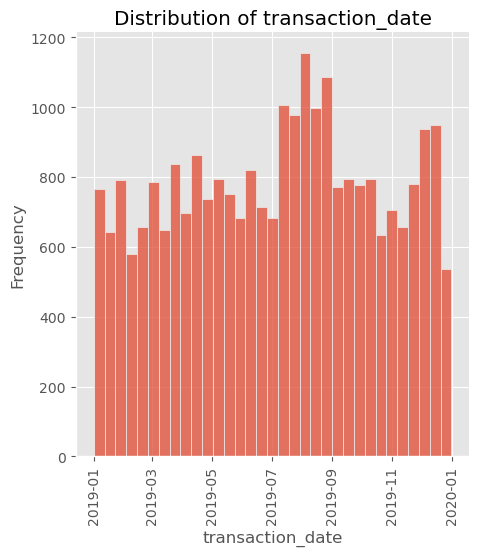

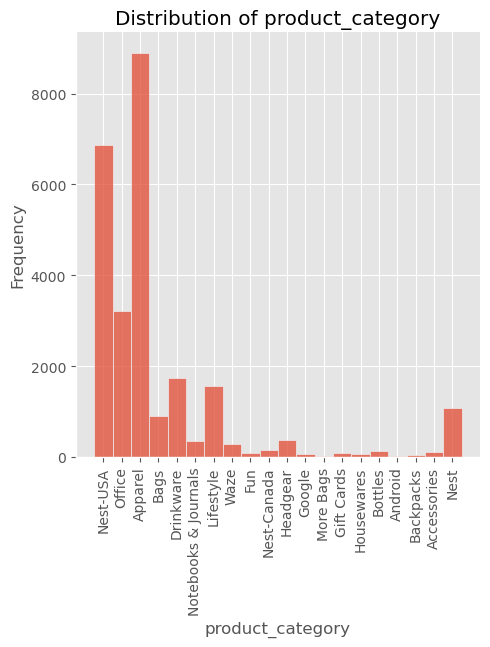

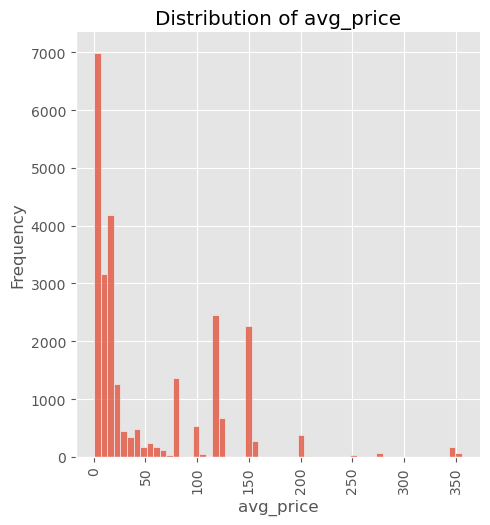

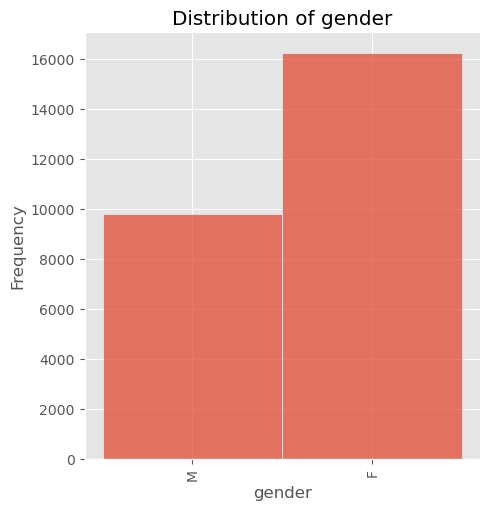

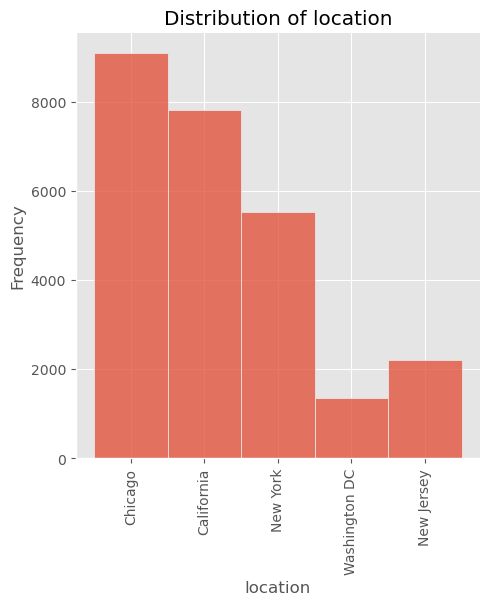

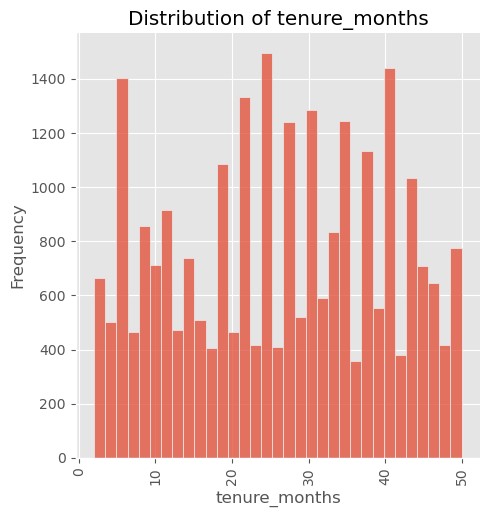

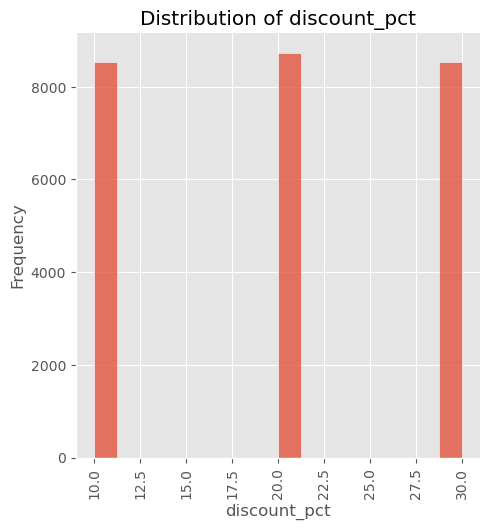

In [7]:
# Make distribution plots for different columns
for column in ['transaction_date', 
               'product_category', 
               'avg_price', 
               'gender', 
               'location',
               'tenure_months', 
               'discount_pct']:
    sns.displot(data[column])
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

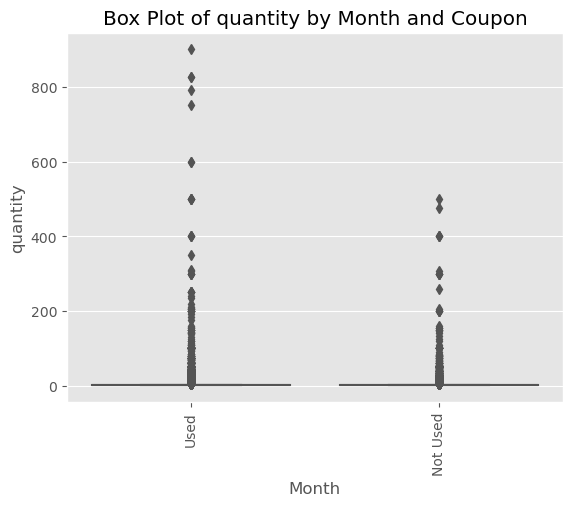

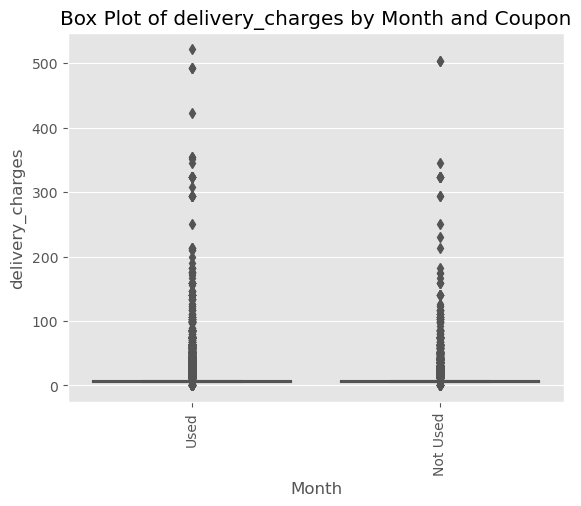

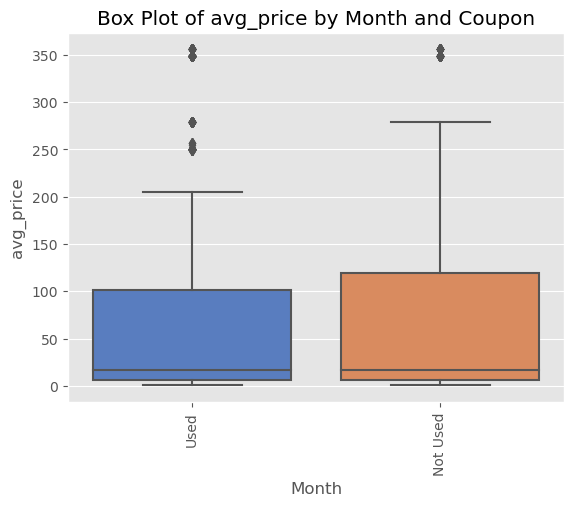

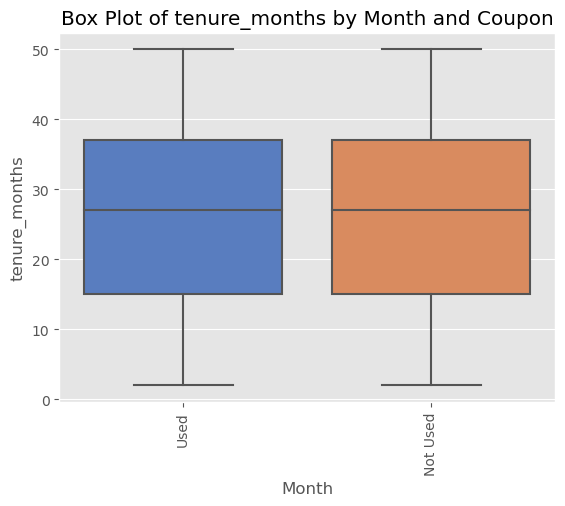

In [8]:
# Make box plots for different columns
for column in ['quantity',
               'delivery_charges',
               'avg_price',
               'tenure_months']:
    # Create the box plot
    sns.boxplot(data=data, x='coupon_status', y=column, palette='muted')
    plt.title(f'Box Plot of {column} by Month and Coupon')
    plt.xlabel('Month')
    plt.ylabel(column)
    # Rotate x-axis tick labels by 90 degrees
    plt.xticks(rotation=90)
    plt.show()

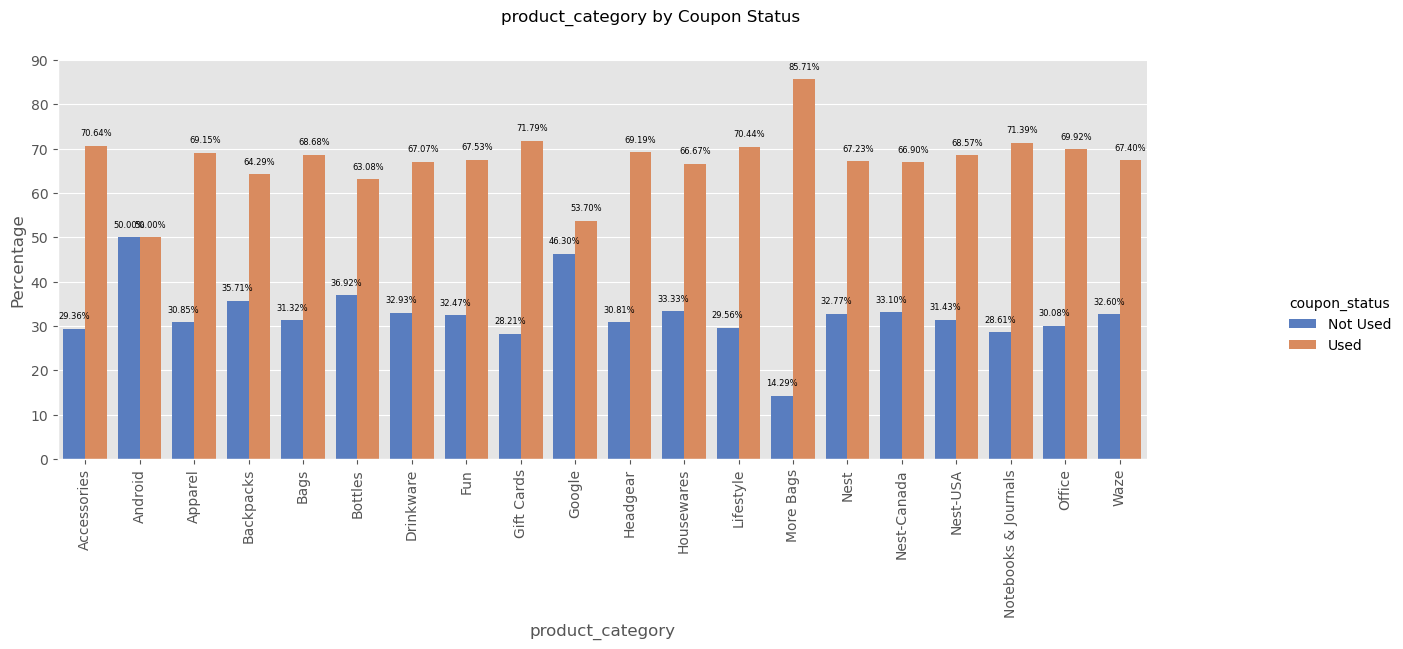

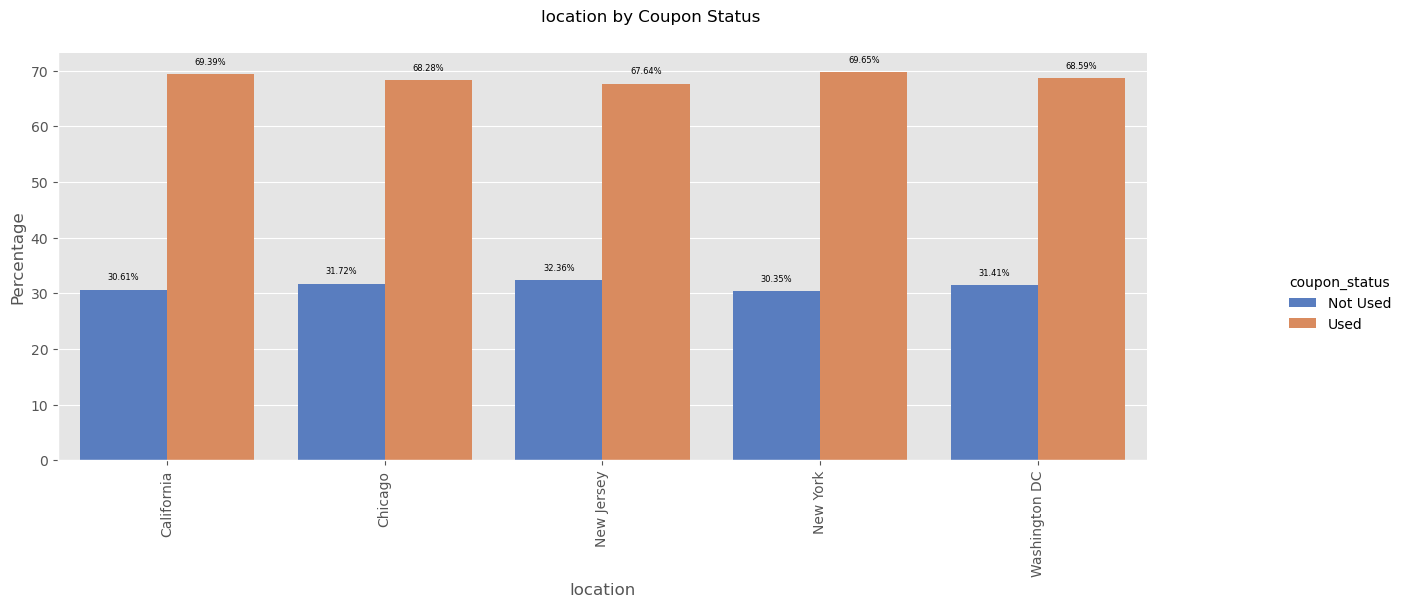

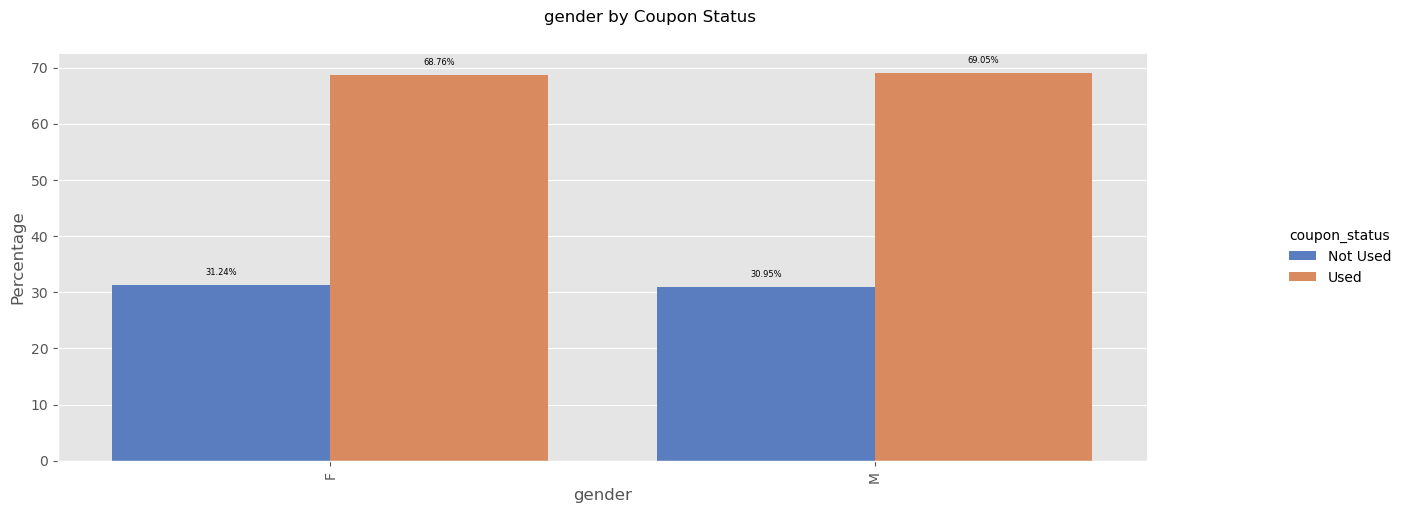

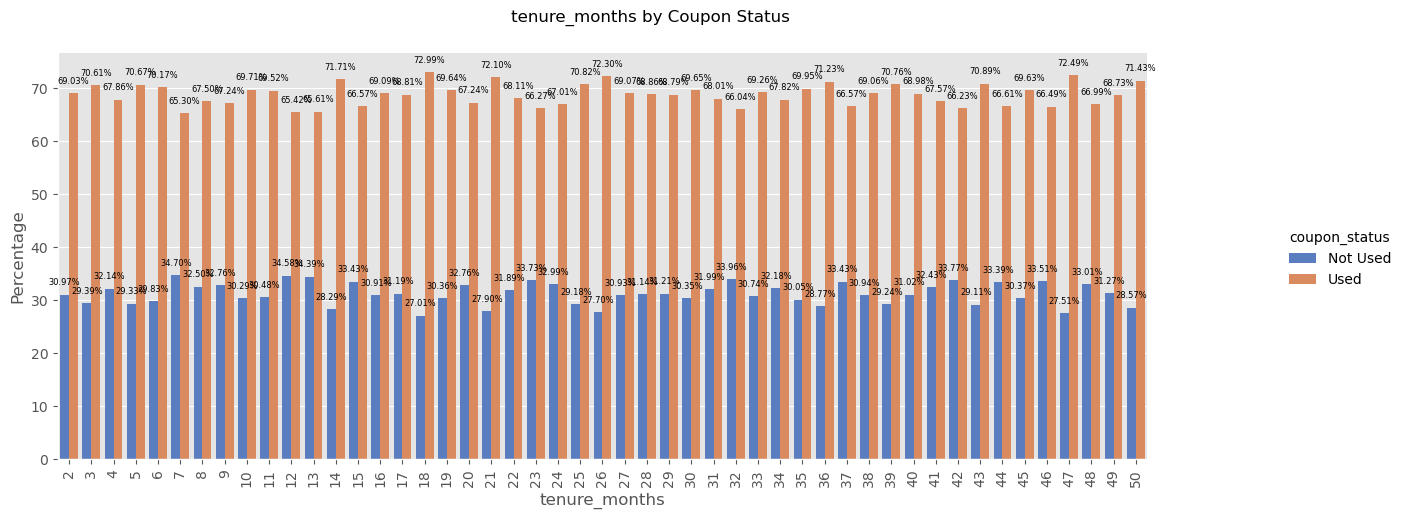

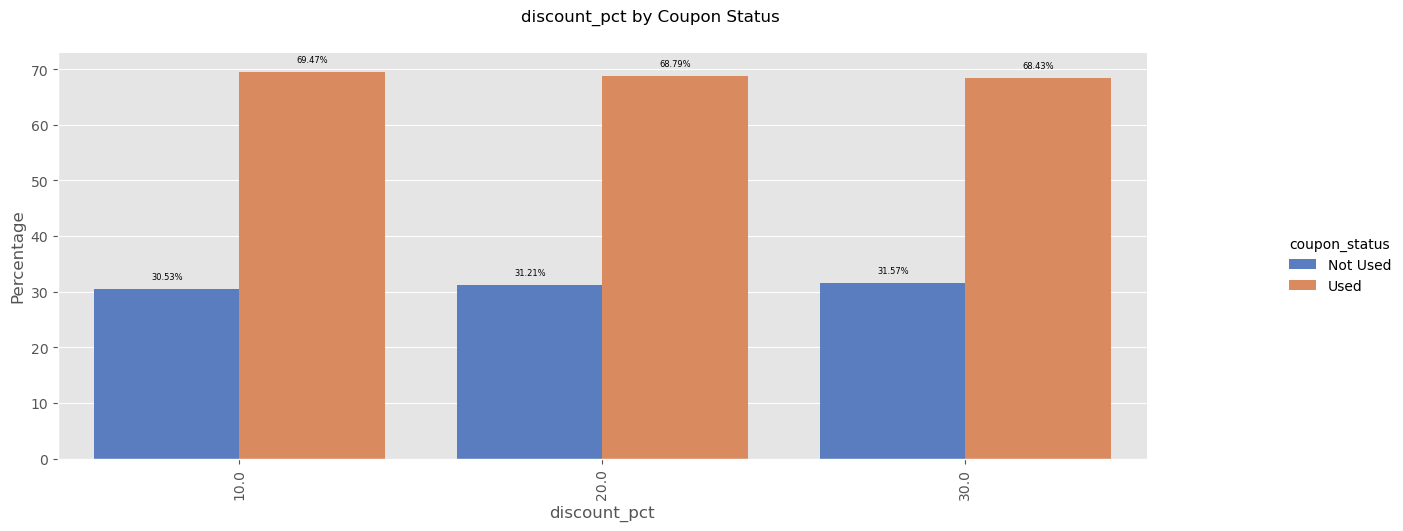

In [9]:
# Create the catplot for different columns; it shows the interdependence between 'coupon status' and and categorical values of particular column
for column in ['product_category',
               'location',
               'gender',
               'tenure_months',
               'discount_pct']:
    # Calculate the percentages
    df_percentage = data.groupby([column, 'coupon_status']).size().reset_index(name='count')
    df_total = data.groupby(column).size().reset_index(name='total')
    df_percentage = pd.merge(df_percentage, df_total, on=column)
    df_percentage['percentage'] = df_percentage['count'] / df_percentage['total'] * 100
    # Create the catplot 
    g = sns.catplot(data=df_percentage, kind='bar', x=column, y='percentage', hue='coupon_status', 
                    height=4, aspect=1.5, palette='muted')
    g.fig.set_size_inches((15, 5))
    # Rotate x-axis tick labels by 90 degrees
    g.set_xticklabels(rotation=90)
    # Function to add labels to the bars
    def add_labels(ax):
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}%', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points', 
                        fontsize=6)
    # Add labels to each subplot
    for ax in g.axes.flat:
        add_labels(ax)
    # Set the titles and labels
    g.set_axis_labels(column, 'Percentage')
    g.set_titles('Percentage of Observations by Coupon Status')
    g.fig.suptitle(f'{column} by Coupon Status', y=1.05)
    plt.show()

<b>Design the A/B Test</b>

Define the Objective:
Determine if the use of discount coupons increases the average order value and transaction volume.

Primary Metrics:
Average order value (AOV)
Total sales volume

Secondary Metrics:
Conversion rate
Customer retention rate

Create Hypotheses:
Null Hypothesis (H0): Discount coupons do not affect the average order value or total sales volume.
Alternative Hypothesis (H1): Discount coupons increase the average order value and total sales volume.
Segment the Audience:

Split customers into two groups based on the 'coupon_status' column:
Group A: Customers who did not use a discount coupon.
Group B: Customers who used a discount coupon.

Duration: Use historical data over a fixed period 1 year.

Randomization: Ensure that the split between coupon users and non-users is random if possible, or consider using propensity score matching to create comparable groups.

<b>Calculate key metrics</b>

In [10]:
# Calculate average order value for each group
aov = data.groupby('coupon_status')['total_amount'].mean()
# Calculate total sales volume for each group
total_sales = data.groupby('coupon_status')['total_amount'].sum()
# Display the results
print('average sum: ', aov, '\n'), print('total sum: ', total_sales)

average sum:  coupon_status
Not Used    100.853312
Used         97.648721
Name: total_amount, dtype: float64 

total sum:  coupon_status
Not Used     816306.71
Used        1748302.70
Name: total_amount, dtype: float64


(None, None)

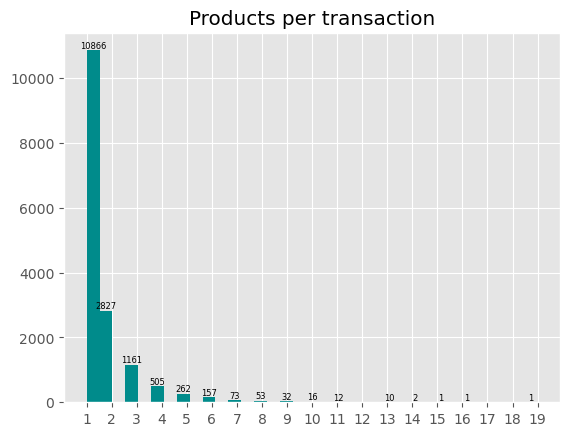

In [11]:
# How many products could be inside one transaction?
transaction_products = data.groupby('transaction_id')\
                            .agg({'transaction_date': 'count'})\
                            .reset_index().sort_values(by='transaction_date', ascending=False)
counts, bins, _ = plt.hist(transaction_products['transaction_date'], bins=35, color='darkcyan')
plt.title('Products per transaction')
plt.xticks(np.arange(int(min(transaction_products['transaction_date'])), int(max(transaction_products['transaction_date'])) + 1, 1))
# Add labels to each bin
for i in range(len(bins) - 1):
    if counts[i] > 0:
        plt.text((bins[i] + bins[i+1]) / 2, counts[i], int(counts[i]), ha='center', va='bottom', fontsize=6)
plt.show()

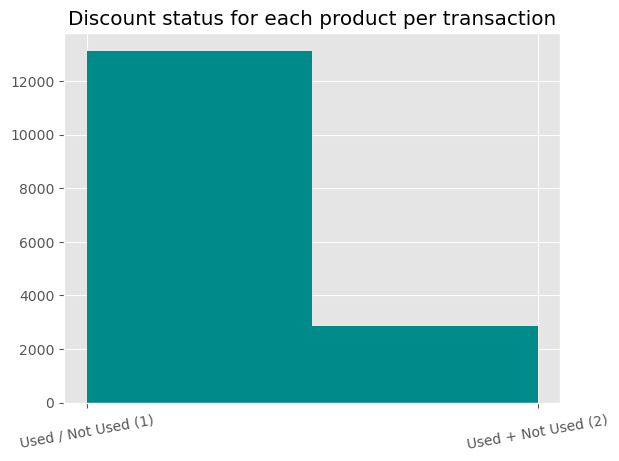

In [12]:
# Does coupon give discount for all products?
transaction_discounts = data.groupby(['transaction_id', 'coupon_status'])\
                            .agg({'product_sku': 'count'})\
                            .reset_index()[['transaction_id']]\
                            .value_counts()
plt.hist(transaction_discounts, color='darkcyan', bins=2)
plt.title('Discount status for each product per transaction')
plt.xticks(np.arange(int(min(transaction_discounts)), int(max(transaction_discounts)) + 1, 1))
# Define custom tick positions and labels
tick_positions = [1, 2]  # Example positions where you want the ticks
# Corresponding labels for the ticks
tick_labels = ['Used / Not Used (1)',  'Used + Not Used (2)']  
# Set custom x-ticks
plt.xticks(tick_positions, tick_labels, rotation=10)
plt.show()

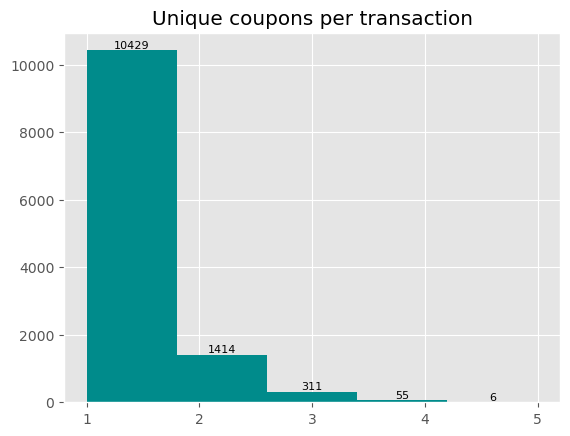

In [13]:
transaction_distinct_coupons = data[data['coupon_status']=='Used'].groupby(['transaction_id'])\
                                .agg({'coupon_code': 'nunique'})\
                                .reset_index()[['coupon_code']]
transaction_distinct_coupons = transaction_distinct_coupons[transaction_distinct_coupons != 0]
counts, bins, _ = plt.hist(transaction_distinct_coupons, bins=5, color='darkcyan')
plt.xticks(np.arange(int(transaction_distinct_coupons.min()), int(transaction_distinct_coupons.max()) + 1, 1))
for i in range(len(bins) - 1):
    if counts[i] > 0:
        plt.text((bins[i] + bins[i+1]) / 2, counts[i], int(counts[i]), ha='center', va='bottom', fontsize=8)
plt.title('Unique coupons per transaction')
plt.show()

Based on above-mentioned findings we conclude that in one transaction:
1. Could exist one or more distinct products
2. Customer could or could not use the coupon. It is also possible to use coupon for some of the products only
3. Customer could use a few distinct coupons

So we will not group data by customers or transactions. Instead, we will use values for each particular product SKU observation.

<b>Statistical tests</b>

<i>T-test for Average Order Value</i>

In [14]:
# Separate the transaction amounts by group
no_coupon = data[data['coupon_status'] == 'Used']['total_amount']
with_coupon = data[data['coupon_status'] == 'Not Used']['total_amount']
# Perform t-test
alpha = 0.05
t_stat, p_value = ttest_ind(no_coupon, with_coupon)
# Interpret the results based on the p-value
print('t_stat: ', t_stat)
print('p_value_aov: ', p_value)
if p_value < alpha:
    print("Reject the null hypothesis - there is a significant difference in average order value between the groups.")
else:
    print("Fail to reject the null hypothesis - no significant difference in average order value between the groups.")

t_stat:  -1.3672682895544501
p_value_aov:  0.17155304892553497
Fail to reject the null hypothesis - no significant difference in average order value between the groups.


We are going to conduct multiple tests to understand how coupons affect sales in different categories: product_category, month,	gender,	location, discount_pct

p-value (Bonferroni): This is the p-value adjusted using the Bonferroni correction method. A Bonferroni-adjusted p-value greater than 0.05 typically indicates that the difference between the groups is not statistically significant after adjusting for multiple comparisons.

p-value (FDR): This is the p-value adjusted using the False Discovery Rate (FDR) correction method (specifically the Benjamini-Hochberg procedure). FDR correction is less conservative than Bonferroni correction and is often preferred when conducting multiple hypothesis tests.

When using the ttest_ind function (independent two-sample t-test) in statistical analysis, it is not strictly necessary to have equal sample sizes for the two groups being compared. However, there are some important considerations to keep in mind regarding sample size equality. 

For example, Equal Variances Assumption. The standard ttest_ind assumes that the two samples have equal variances. If the sample sizes are unequal, this assumption becomes more critical because the test is more sensitive to violations of the equal variances assumption when sample sizes differ. To address this, you can use the equal_var=False option in ttest_ind, which applies Welch's t-test, which does not assume equal variances.

In [15]:
# Write a function to perform pairwise t-tests for each combination of groups in filtered dataset (coupon_status='Used')
def pairwise_ttest(df, value, category):
    results = []
    for group1, group2 in combinations(df[category].unique(), 2):
        data_group1 = df[df[category] == group1][value]
        data_group2 = df[df[category] == group2][value]
        # Perform Levene's test to assess the equality of variances for a variable calculated for two or more groups
        stat, levene_p_value = levene(data_group1, data_group2)
        if levene_p_value > 0.05:
            variances_equal = True
        else:
            variances_equal = False
        # Perform t-test
        t_stat, p_val = ttest_ind(data_group1, data_group2, equal_var=variances_equal)
        results.append({'group1': group1, 'group2': group2, 't_stat': t_stat, 'p_val': p_val})
    # Extract raw p-values
    raw_p_values = [result['p_val'] for result in results]
    # Apply Bonferroni correction
    adjusted_p_values_bonf = multipletests(raw_p_values, method='bonferroni')[1]
    # Apply FDR correction (Benjamini-Hochberg procedure)
    adjusted_p_values_fdr = multipletests(raw_p_values, method='fdr_bh')[1]
    print(f"\n\033[1mPairwise t-tests within category: {category} \033[0m\n")
    # Print results
    for idx, result in enumerate(results):
        print(f"Comparison {idx+1}: Group {result['group1']} vs Group {result['group2']}, "
              f"p-value (raw): {result['p_val']:.6f}, "
              f"p-value (Bonferroni): {adjusted_p_values_bonf[idx]:.6f}, "
              f"p-value (FDR): {adjusted_p_values_fdr[idx]:.6f}, "
              f"variances are equal: {variances_equal}")
        
# Write a function to perform t-tests for each particular category to understand an impact of coupon usage
def categorical_ttest(df, value, categories):
    grouped = df.groupby([categories, 'coupon_status'])[value].apply(list).reset_index()
    # Perform t-test for every category 
    results = []
    for cat in df[categories].unique():
        data_used = grouped[(grouped[categories] == cat) & (grouped['coupon_status'] == 'Used')][value].values[0]
        data_not_used = grouped[(grouped[categories] == cat) & (grouped['coupon_status'] == 'Not Used')][value].values[0]
         # Perform Levene's test to assess the equality of variances for a variable calculated for two or more groups
        stat, levene_p_value = levene(data_used, data_not_used)
        if levene_p_value > 0.05:
            variances_equal = True
        else:
            variances_equal = False
        t_stat, p_val = ttest_ind(data_used, data_not_used, equal_var=variances_equal)
        results.append({
            categories : cat,
            't_statistic': t_stat,
            'p_value': p_val
        })
    # Print results
    print(f"\n\033[1mImpact of coupon usage on sales within category: {categories} \033[0m\n")
    for result in results:
        print(f"{categories} {result[categories]}: " 
              f"t-statistic = {result['t_statistic']:.4f}, "
              f"p-value = {result['p_value']:.4f}, "
              f"variances are equal: {variances_equal}")

In [16]:
data['discount_pct'] = data['discount_pct'].astype(str)
for category in 'product_category', 'month', 'gender', 'location', 'discount_pct':
    categorical_ttest(data, 'total_amount', category)
    pairwise_ttest(data[data['coupon_status'] == 'Used'], 'total_amount', category)
    print(50 * '=')



Impact of coupon usage on sales within category: product_category 

product_category Nest-USA: t-statistic = -0.1789, p-value = 0.8580, variances are equal: True
product_category Office: t-statistic = 1.2249, p-value = 0.2207, variances are equal: True
product_category Apparel: t-statistic = -1.5565, p-value = 0.1196, variances are equal: True
product_category Bags: t-statistic = -1.5432, p-value = 0.1231, variances are equal: True
product_category Drinkware: t-statistic = -1.0000, p-value = 0.3175, variances are equal: True
product_category Notebooks & Journals: t-statistic = -1.8789, p-value = 0.0611, variances are equal: True
product_category Lifestyle: t-statistic = 0.1741, p-value = 0.8618, variances are equal: True
product_category Waze: t-statistic = -1.3180, p-value = 0.1886, variances are equal: True
product_category Fun: t-statistic = -0.9064, p-value = 0.3676, variances are equal: True
product_category Nest-Canada: t-statistic = -1.1211, p-value = 0.2642, variances are equa


Pairwise t-tests within category: month 

Comparison 1: Group 2019-01 vs Group 2019-02, p-value (raw): 0.308502, p-value (Bonferroni): 1.000000, p-value (FDR): 0.363592, variances are equal: False
Comparison 2: Group 2019-01 vs Group 2019-03, p-value (raw): 0.000134, p-value (Bonferroni): 0.008860, p-value (FDR): 0.000295, variances are equal: False
Comparison 3: Group 2019-01 vs Group 2019-04, p-value (raw): 0.700741, p-value (Bonferroni): 1.000000, p-value (FDR): 0.734110, variances are equal: False
Comparison 4: Group 2019-01 vs Group 2019-05, p-value (raw): 0.000000, p-value (Bonferroni): 0.000000, p-value (FDR): 0.000000, variances are equal: False
Comparison 5: Group 2019-01 vs Group 2019-06, p-value (raw): 0.000000, p-value (Bonferroni): 0.000005, p-value (FDR): 0.000000, variances are equal: False
Comparison 6: Group 2019-01 vs Group 2019-07, p-value (raw): 0.000000, p-value (Bonferroni): 0.000000, p-value (FDR): 0.000000, variances are equal: False
Comparison 7: Group 2019-01


Pairwise t-tests within category: discount_pct 

Comparison 1: Group 10.0 vs Group nan, p-value (raw): 0.467391, p-value (Bonferroni): 1.000000, p-value (FDR): 0.701086, variances are equal: True
Comparison 2: Group 10.0 vs Group 20.0, p-value (raw): 0.357032, p-value (Bonferroni): 1.000000, p-value (FDR): 0.701086, variances are equal: True
Comparison 3: Group 10.0 vs Group 30.0, p-value (raw): 0.757476, p-value (Bonferroni): 1.000000, p-value (FDR): 0.757476, variances are equal: True
Comparison 4: Group nan vs Group 20.0, p-value (raw): 0.592993, p-value (Bonferroni): 1.000000, p-value (FDR): 0.711592, variances are equal: True
Comparison 5: Group nan vs Group 30.0, p-value (raw): 0.244262, p-value (Bonferroni): 1.000000, p-value (FDR): 0.701086, variances are equal: True
Comparison 6: Group 20.0 vs Group 30.0, p-value (raw): 0.165958, p-value (Bonferroni): 0.995750, p-value (FDR): 0.701086, variances are equal: True
